In [211]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import cross_val_score, cross_val_predict

from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

In [212]:
train_set = pd.read_csv('../data/train.csv')
test_set = pd.read_csv('../data/test.csv')

In [213]:
test_set.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


In [214]:
def cat_plot(df, feature_name, target_name, palettemap): 
    fig, [axis0,axis1] = plt.subplots(1,2,figsize=(10,5))
    df[feature_name].value_counts().plot.pie(autopct='%1.1f%%',ax=axis0)
    sns.countplot(x=feature_name, hue=target_name, data=df,
                  palette=palettemap,ax=axis1)
    plt.show()

    
survival_palette = {0: "black", 1: "orange"} 

## Pclass

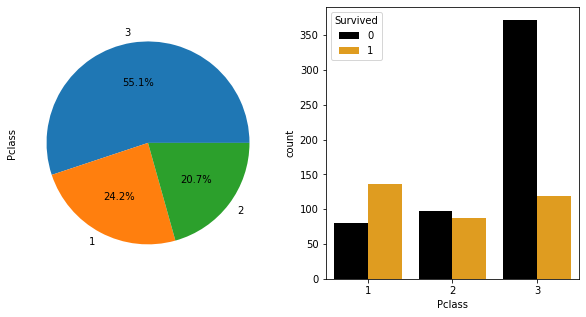

In [215]:
cat_plot(train_set, 'Pclass','Survived', survival_palette)

## Sex

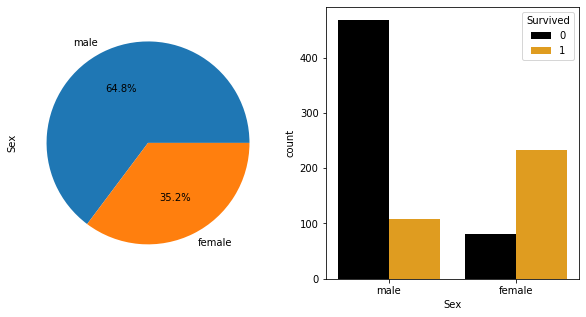

In [216]:
cat_plot(train_set, 'Sex','Survived', survival_palette)

## SibSp

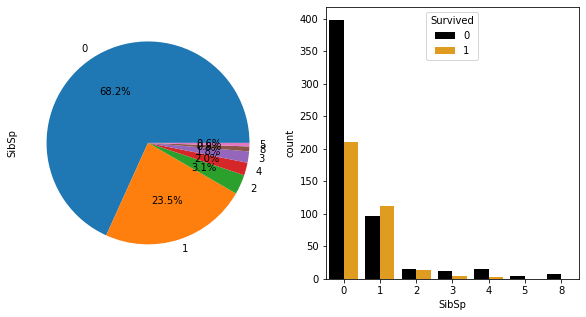

In [217]:
cat_plot(train_set, 'SibSp', 'Survived', survival_palette)

## Parch

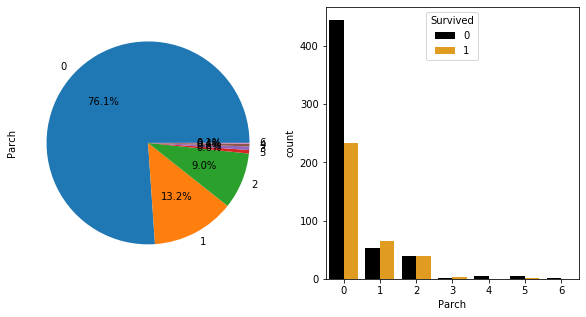

In [218]:
cat_plot(train_set, 'Parch', 'Survived', survival_palette)

## The percentage of survivors

In [219]:
survived = round((len(data.Survived[data.Survived == 1]) / data.Survived.count())*100, 2)
print(f'The percentage of survivors peoples: {survived}')

The percentage of survivors peoples: 38.38


## Age

In [220]:
mean_age = round(data.Age.mean(), 2)
med_age = data.Age.median()
print(f'Mean: {mean_age}')
print(f'Median: {med_age}')

Mean: 29.7
Median: 28.0


## Dataset Cleanup

In [221]:
combined_set = [train_set, test_set]

for dataset in combined_set:
    dataset["Age"].fillna(dataset["Age"].median(), inplace=True)
    dataset["Fare"].fillna(dataset["Fare"].median(), inplace=True)

train_set["Embarked"].fillna(train_set["Embarked"].value_counts().index[0], inplace=True)

In [222]:
age_bins = [0,15,35,45,60,200]
age_labels = ['15-','15-35','35-45','40-60','60+']
fare_bins = [0,10,30,60,999999]
fare_labels = ['10-','10-30','30-60','60+']

def get_title(dataset, feature_name):
    return dataset[feature_name].map(lambda name:name.split(',')[1].split('.')[0].strip())

for dataset in combined_set:
    dataset['AgeRange'] = pd.cut(dataset['Age'], bins=age_bins, labels=age_labels, include_lowest=True)
    dataset['FareRange'] = pd.cut(dataset['Fare'], bins=fare_bins, labels=fare_labels, include_lowest=True)
    dataset['FamilySize'] = dataset['SibSp'] + train_set['Parch']
    dataset['HasCabin'] = dataset['Cabin'].notnull().astype(int)
    dataset['Title'] = get_title(dataset, 'Name')

In [223]:
for dataset in combined_set:
    dataset['Family'] = ''
    dataset.loc[dataset['FamilySize'] == 0, 'Family'] = 'alone'
    dataset.loc[(dataset['FamilySize'] > 0) & (dataset['FamilySize'] <= 3), 'Family'] = 'small'
    dataset.loc[(dataset['FamilySize'] > 3) & (dataset['FamilySize'] <= 6), 'Family'] = 'medium'
    dataset.loc[dataset['FamilySize'] > 6, 'Family'] = 'large'

In [224]:
title_dict = {
                "Mr" :        "Mr",
                "Miss" :      "Miss",
                "Mrs" :       "Mrs",
                "Master" :    "Master",
                "Dr":         "Scholar",
                "Rev":        "Religious",
                "Col":        "Officer",
                "Major":      "Officer",
                "Mlle":       "Miss",
                "Don":        "Noble",
                "the Countess":"Noble",
                "Ms":         "Mrs",
                "Mme":        "Mrs",
                "Capt":       "Noble",
                "Lady" :      "Noble",
                "Sir" :       "Noble",
                "Jonkheer":   "Noble"
            }

for dataset in combined_set:
    dataset['TitleGroup'] = dataset.Title.map(title_dict)

In [225]:
test_set.at[414, 'TitleGroup'] = 'Noble'

In [226]:
X_train = train_set.drop(['Survived','PassengerId','Name','Age','Fare','Ticket','Cabin','SibSp','Parch','Title','FamilySize'], axis=1)
X_test = test_set.drop(['PassengerId','Name','Age','Fare','Ticket','Cabin','SibSp','Parch','Title','FamilySize'], axis=1)

y_train = train_set['Survived']

In [227]:
X_train_analysis = X_train.copy()
X_train_analysis['Sex'] = X_train_analysis['Sex'].map({'male': 0, 'female': 1}).astype(int)
X_train_analysis['Embarked'] = X_train_analysis['Embarked'].map({'C': 0, 'Q': 1, 'S': 2}).astype(int)
X_train_analysis['Family'] = X_train_analysis['Family'].map({'alone': 0, 'small': 1, 'medium': 2, 'large': 3}).astype(int)

agerange_dict = dict(zip(age_labels, list(range(len(age_labels)))))
X_train_analysis['AgeRange'] = X_train_analysis['AgeRange'].map(agerange_dict).astype(int)

farerange_dict = dict(zip(fare_labels, list(range(len(fare_labels)))))
X_train_analysis['FareRange'] = X_train_analysis['FareRange'].map(farerange_dict).astype(int)

titlegroup_labels = list(set(title_dict.values()))
titlegroup_dict = dict(zip(titlegroup_labels, list(range(len(titlegroup_labels)))))
X_train_analysis['TitleGroup'] = X_train_analysis['TitleGroup'].map(titlegroup_dict).astype(int)

In [228]:
rforest_checker = RandomForestClassifier(random_state = 0)
rforest_checker.fit(X_train_analysis, y_train)
importances_df = pd.DataFrame(rforest_checker.feature_importances_, columns=['Feature_Importance'],
                              index=X_train_analysis.columns)
importances_df.sort_values(by=['Feature_Importance'], ascending=False, inplace=True)
print(importances_df)

            Feature_Importance
Sex                   0.271906
TitleGroup            0.184821
Pclass                0.119876
Family                0.104346
FareRange             0.100285
AgeRange              0.097639
HasCabin              0.063831
Embarked              0.057296


In [229]:
X_train = X_train.drop(['HasCabin','Embarked'], axis=1)
X_test = X_test.drop(['HasCabin','Embarked'], axis=1)

In [230]:
X_train = pd.get_dummies(X_train, columns=['TitleGroup','Family','Pclass','Sex','AgeRange','FareRange'])
X_test = pd.get_dummies(X_test, columns=['TitleGroup','Family','Pclass','Sex','AgeRange','FareRange'])

In [231]:
X_train = X_train.drop(['Pclass_1','Sex_female','TitleGroup_Master','AgeRange_15-','FareRange_10-','Family_alone', 'TitleGroup_Noble'], axis=1)
X_test = X_test.drop(['Pclass_1','Sex_female','TitleGroup_Master','AgeRange_15-','FareRange_10-','Family_alone', 'TitleGroup_Noble'], axis=1)

In [232]:
params_rforest = [{'n_estimators': [200, 300],
                   'max_depth': [5, 7, 10],
                   'min_samples_split': [2, 4]}]
grid_rforest = GridSearchCV(estimator = RandomForestClassifier(criterion = 'gini', 
                                                               random_state = 0, n_jobs=-1),
                            param_grid = params_rforest,
                            scoring = 'accuracy',
                            cv = 10,
                            n_jobs=-1)
grid_rforest = grid_rforest.fit(X_train, y_train)
best_acc_rforest = grid_rforest.best_score_
best_params_rforest = grid_rforest.best_params_

In [233]:
params_dtree = [{'min_samples_split': [5, 10, 15, 20],
                 'min_samples_leaf': [1, 2, 3],
                 'max_features': ['auto', 'log2']}]
grid_dtree = GridSearchCV(estimator = DecisionTreeClassifier(criterion = 'gini', 
                                                             random_state = 0),
                            param_grid = params_dtree,
                            scoring = 'accuracy',
                            cv = 10,
                            n_jobs=-1)
grid_dtree = grid_dtree.fit(X_train, y_train)
best_acc_dtree = grid_dtree.best_score_
best_params_dtree = grid_dtree.best_params_

In [234]:
params_ksvm = [{'C': [0.1, 1, 10, 100], 'kernel': ['linear']},
               {'C': [0.1, 1, 10, 100], 'kernel': ['rbf'],
                'gamma': [0.1, 0.2, 0.3, 0.4, 0.5]},
               {'C': [0.1, 1, 10, 100], 'kernel': ['poly'],
                'degree': [1, 2, 3],
                'gamma': [0.1, 0.2, 0.3, 0.4, 0.5]}]
grid_ksvm = GridSearchCV(estimator = SVC(random_state = 0),
                         param_grid = params_ksvm,
                         scoring = 'accuracy',
                         cv = 10,
                         n_jobs=-1)
grid_ksvm = grid_ksvm.fit(X_train, y_train)  
best_acc_ksvm = grid_ksvm.best_score_
best_params_ksvm = grid_ksvm.best_params_

In [235]:
grid_score_dict = {'Best Score': [best_acc_ksvm,best_acc_dtree,best_acc_rforest],
                   'Optimized Parameters': [best_params_ksvm,best_params_dtree,best_params_rforest],
                  }
pd.DataFrame(grid_score_dict, index=['Kernel SVM','Decision Tree','Random Forest'])

,Best Score,Optimized Parameters
Kernel SVM,0.835019,"{'C': 1, 'gamma': 0.4, 'kernel': 'rbf'}"
Decision Tree,0.820449,"{'max_features': 'auto', 'min_samples_leaf': 1..."
Random Forest,0.839538,"{'max_depth': 7, 'min_samples_split': 4, 'n_es..."


In [236]:
rforest = RandomForestClassifier(max_depth = 7, min_samples_split=4, n_estimators = 200, random_state = 0) # Grid Search best parameters
rforest.fit(X_train, y_train)
y_pred_train_rforest = cross_val_predict(rforest, X_train, y_train)
y_pred_test_rforest = rforest.predict(X_test)

In [238]:
rforest.score(X_train, y_train)

0.8484848484848485

In [ ]:
X_test.head()